In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('C:/Users/Жора/Downloads/tz_data.csv')

### Загрузка данных

In [3]:
data.head()

,area,cluster,cluster_name,keyword,good (1),count,x,y
0,eligibility,0.0,Кластер 0,several animated buried,1.0,1260,5.772342,12.564796257345005
1,eligibility,0.0,Кластер 0,singles unusual buyers,1.0,866,14.829280,7.8507285727125815
2,eligibility,0.0,Кластер 0,hawaiian directive,1.0,163,11.381856,3.8981370219558604
3,eligibility,0.0,Кластер 0,dynamics directly,1.0,1146,9.980149,6.281427914064545
4,eligibility,1.0,Кластер 1,decision surgeons montreal,1.0,823,3.283940,4.39674063521296


### Предобработка данных

В выходной таблице должны остаться только следующие колонки:
area, cluster, cluster_name, keyword, x, y, count, color, где
 area - область,
 cluster - номер кластера,
 cluster_name - название кластера,
 keyword - словосочетание,
 count - показатель,
 x и y - координаты для диаграммы рассеяния,
 color - цвет точки на карте для данного словосочетания


good (1) - удаляю

In [4]:
data = data.drop('good (1)', axis=1)

#### Общая информация

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          228 non-null    object 
 1   cluster       228 non-null    float64
 2   cluster_name  228 non-null    object 
 3   keyword       228 non-null    object 
 4   count         227 non-null    object 
 5   x             228 non-null    float64
 6   y             228 non-null    object 
dtypes: float64(2), object(5)
memory usage: 12.6+ KB


In [6]:
data.describe()

,cluster,x
count,228.000000,228.000000
mean,1.399123,7.654747
std,1.079810,4.374202
min,0.000000,0.039448
25%,0.000000,3.595513
50%,1.000000,8.039071
75%,2.000000,11.386263
max,3.000000,14.927879


#### Поиск дубликатов

In [7]:
display(f'Найдено дубликатов в данных = {data.duplicated().sum()}')

'Найдено дубликатов в данных = 0'

##### Проверить дубликаты по нескольким полям

In [8]:
data.duplicated(['area','keyword','x','y']).sum()

3

При проверке данных на дубликаты по полям area, keyword, x и y найдено 3 дубликата, ниже удалю их.

In [9]:
data = data.drop_duplicates(subset=['area','keyword','x','y'], keep=False)

In [10]:
data.shape

(223, 7)

##### Поиск пропусков

In [11]:
data.isnull().sum()

area            1
cluster         1
cluster_name    1
keyword         1
count           2
x               1
y               1
dtype: int64

In [12]:
is_null = data.isnull()

сформировать Series, которая нам послужит в дальнейшем фильтром, в которой значение True будет в случае, если хотя бы в одном столбце в строке нет данных, а False, если информация есть во всех столбцах:

In [13]:
row_null = is_null.any(axis=1)

Используя эту Series как фильтр, мы создаем новый Dataframe, в который переносим только те строки, в которых хотя бы в одном из столбцов есть NaN:

In [14]:
row_null = data[row_null]

In [15]:
row_null

,area,cluster,cluster_name,keyword,count,x,y
178,housewives,2.0,Кластер 2,outstanding relations,NaN,1.289158,6.397514584626231
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data = data.drop(labels = [193],axis = 0).reset_index(drop=True)

Удалю строку 193 - в ней одни пропуски, в строке 178 заменю пропуск на 0, какое значение в count было я не знаю, это занчение буду иметь в виду как одно подозрительное если в дальнейшем можно его будет исправить.

In [17]:
data = data.fillna(0)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          222 non-null    object 
 1   cluster       222 non-null    float64
 2   cluster_name  222 non-null    object 
 3   keyword       222 non-null    object 
 4   count         222 non-null    object 
 5   x             222 non-null    float64
 6   y             222 non-null    object 
dtypes: float64(2), object(5)
memory usage: 12.3+ KB


In [19]:
data.isnull().sum()

area            0
cluster         0
cluster_name    0
keyword         0
count           0
x               0
y               0
dtype: int64

Пропуски удалены. далее посмотрю на аномалии в данных если они имеются

In [20]:
data['y'].unique()

array(['12.564796257345005', '7.8507285727125815', '3.8981370219558604',
       '6.281427914064545', '4.39674063521296', '13.155189236409358',
       '3.1617111286924686', '2.9656951192720844', '7.172434500682598',
       '10.281612538543575', '3.5805593604528685', '2.5133519530949426',
       '12.968220386038821', '2.9597385853299247', '11.241094130877395',
       '7.862178589057771', '5.090565770201748', '4.886067287286476',
       '12.515576283697598', '7.3790401213355254', '6.577019046472794',
       '4.840058228742469', '0.3976214750666285', '7.635234264470194',
       '5.853697603739591', '12.11758463166844', '4.0716830744657715',
       '0.7269788262356514', '8.184505216288963', '7.201312159374234',
       '14.56834807581583', '14.838972733370907', '5.807535729499952',
       '6.234035288942436', '12.985122559024818', '2.8545670858213916',
       '14.817618017689076', '12.305153970991967', '10.48899638751125',
       '6.513206893783746', '14.374205517890555', '4.206470020157055'

In [21]:
data['count'].unique()

array(['1260', '866', '163', '1146', '823', '1377', '281', '1501', '309',
       '129', '1817', '23', '1795', '1013', '1184', '114', '203', '1047',
       '683', '563', '1532', '813', '1703', '1986', '763', '1928', '1949',
       '411', '1433', '1694', '1901', '426', '1793', '1247', '910', '907',
       '1041', '1404', '454', '1037', '401', '1749', '649', '99', '1206',
       '1022', 'N\\A', '1818', '1455', '936', '1705', '904', '697',
       '1547', '1725', '374', '1197', '480', '19', '1421', '161', '1803',
       '1384', '1727', '1393', '347', '428', '1667', '1158', '818', '536',
       '661', '1011', '1831', '1451', '421', '501', '1737', '469', '659',
       '1054', '1059', '178', '1869', '836', '1866', '973', '1335',
       '1062', '1499', '381', '1050', '1159', '1785', '471', '1382',
       '236', '1476', '1097', '1653', '1443', '586', '751', '173', '1397',
       '773', '1007', '715', '682', '889', '1249', '172', '1189', '260',
       '1669', '691', '670', '1713', '1920', '535', 

Имеются аномальные данные - count ="-",count ="N\\A" и y="0x414fe002", y значению удалю так как тут явно ошибка и если даже переводить из 16-й системы в десятичную получится 109575373010, что вызывает подозрение., значения по count заменю на 0.

In [22]:
data = data.query('y!="0x414fe002"')

In [23]:
data = data.replace({'-':'0','N\\A':'0'})

#### Изменение формата столбцов

In [24]:
data['y'] = data['y'].astype(float)
data['count'] = data['count'].astype(float)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 221
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          221 non-null    object 
 1   cluster       221 non-null    float64
 2   cluster_name  221 non-null    object 
 3   keyword       221 non-null    object 
 4   count         221 non-null    float64
 5   x             221 non-null    float64
 6   y             221 non-null    float64
dtypes: float64(4), object(3)
memory usage: 13.8+ KB


#### Сортировка данных 

Сортировка должна происходить по колонкам area, cluster, cluster_name, count

In [26]:
data = data.sort_values(['area', 'cluster_name','count'], ascending=[True, True, False])

In [27]:
data = data.reset_index(drop=True)
data.head()

,area,cluster,cluster_name,keyword,count,x,y
0,ar\vr,0.0,Кластер 0,written conflict fabulous,1443.0,2.991167,7.106799
1,ar\vr,0.0,Кластер 0,reservations linking,751.0,10.195602,12.259496
2,ar\vr,0.0,Кластер 0,interfaces neutral,586.0,10.443533,13.809915
3,ar\vr,0.0,Кластер 0,committees parallel,173.0,6.735260,3.613983
4,ar\vr,1.0,Кластер 1,postcards looked republic detector,1397.0,10.474474,6.220012


#### Изменение написания

In [28]:
data['area'].unique()

array(['ar\\vr', 'available', 'capability', 'dialog', 'eligibility',
       'except', 'greetings', 'housewives', 'lithuania', 'locator',
       'personnel', 'protein', 'twisted', 'winner', 'worlds'],
      dtype=object)

In [29]:
data = data.replace({'ar\\vr': 'ar-vr'})
data = data.replace({'written conflict fabulous': 'written con fab'})
data = data.replace({'reservations linking': 'res-s linking'})
data = data.replace({'interfaces neutral': 'int-s neut'})
data = data.replace({'committees parallel': 'comm parallel'})
data = data.replace({'programmer cardiovascular billion': 'programmer card-r billion'})
data = data.replace({'postcards looked republic detector': 'post-looked-rep-detector'})
data = data.replace({'hawaiian directive': 'hawaiian'})
data = data.replace({'massage sufficiently': 'massage'})
data = data.replace({'optimal artificial orders': 'optimal-orders'})
data = data.replace({'optimal artificial orders concrete': 'artificial concrete'})
data = data.replace({'announces independent coaching travelers': 'announces travelers'})
data = data.replace({'announces independent latter senator': 'announces senator'})
data = data.replace({'jacksonville tomatoes alberta': 'jacksonville alberta'})
data = data.replace({'recipients phentermine attorneys': 'jrecipients attorneys'})
data = data.replace({'jacksonville tomatoes alberta': 'jacksonville alberta'})
data = data.replace({'courtesy textiles diameter': 'courtesy diameter'})
data = data.replace({'optimal artificial orders complicated': 'optimal complicated'})
data = data.replace({'minerals precipitation voyeurweb': 'minerals voyeurweb'})
data = data.replace({'bestsellers enterprise promotional': 'bestsellers promotional'})
data = data.replace({'suggestion testimonials': 'sugg-testimonials'})
data = data.replace({'ireland discipline': 'ir-disc'})
data = data.replace({'perfectly department composer': 'perfectly composer'})
data = data.replace({'justin thailand inspection': 'justin inspection'})
data = data.replace({'recipients phentermine attorneys': 'recipients attorneys'})
data = data.replace({'portuguese bathroom': 'port bath'})
data = data.replace({'programmer card-r billion': 'prog-billion'})
data = data.replace({'previously standing languages commands': 'previously-commands'})
data = data.replace({'ireland discipline': 'ir-disc'})
data = data.replace({'integral unified': 'integral un'})
data = data.replace({'perfectly composer': 'perf composer'})

#### Добавление колонки color

In [30]:
data['color'] = ""

Цвет задается каждому словосочетанию согласно следующими правилам:
внутри одной области цвета словосочетаний в одном кластере должны быть одинаковые, в разных - отличаться (например, у "Кластер 1" все слова будут окрашены в красный, у "Кластер 2" - в зеленый и т.д.)
цвета кластеров в разных областях могут повторяться
цвета кластеров в разных областях с разным номером не имеют никакой связи (у одной области [area] слова из "Кластер 1" могут быть красного цвета, в другой области у слов из "Кластер 1" может быть другой цвет)

In [31]:
col =""
def color(row):
    global col
    if row['cluster_name'] == "Кластер 1":
        col = '#ff7f0e'
    if row['cluster_name'] == "Кластер 2":
        col = '#2ca02c'
    if row['cluster_name'] == "Кластер 3":
        col = '#d62728'
    if row['cluster_name'] == "Кластер 0":
        col = '#0000ff'
    return col
data['color'] = data.apply(color, axis=1)

#### Экспорт таблицы после предобработки

In [49]:
data.to_csv('data.csv', index=False)

Далее по заданию для каждой области нужно построить график рассеивания, выделю данные в отдельные переменные согласно облсастям

In [32]:
data_cap = data.query('area=="capability"').reset_index(drop=True)
data_ava = data.query('area=="available"').reset_index(drop=True)
data_pr = data.query('area=="protein"').reset_index(drop=True)
data_win = data.query('area=="winner"').reset_index(drop=True)
data_loc = data.query('area=="locator"').reset_index(drop=True)
data_wor = data.query('area=="worlds"').reset_index(drop=True)
data_ar = data.query('area=="ar-vr"').reset_index(drop=True)
data_lit = data.query('area=="lithuania"').reset_index(drop=True)
data_per = data.query('area=="personnel"').reset_index(drop=True)
data_hou = data.query('area=="housewives"').reset_index(drop=True)
data_dia = data.query('area=="dialog"').reset_index(drop=True)
data_exc = data.query('area=="except"').reset_index(drop=True)
data_el = data.query('area=="eligibility"').reset_index(drop=True)
data_tw = data.query('area=="twisted"').reset_index(drop=True)


### Вывод - при предобработке данных было найдено 
- имеються пропуски в 193 строке - все данные пропущены, и в 178 - пропуск в занчении count - заменил на - 0 
- есть аномальные значение в count и координате у, данные в у - удалил, по count заменил на -0 , итого есть 3 значения 
- не стал значения удалять так как коорданты для построения есть и в дальнейшем возможно будет исправить так как сортировка данных идет по count
- нашел 3 дубликата по данным - удалил
- для удобства работы часть имен заменил на более короткое написание
- обработал данные для дальнейшго построения графиков

### Построение графиков

На основании обработанных данных постройте по одной диаграмме рассеяния для каждой области (area) 
Требования к визуализации:
    - Наличие Footer-подписи на изображении
    - Наличие легенды цветов и кластеров
    - Перенос слишком длинных словосочетаний 
    - Минимизация наложения (слепливания) подписей к друг на друга (постарайтесь сделать так, чтобы наложение было минимальным)
    - Обводка точек.

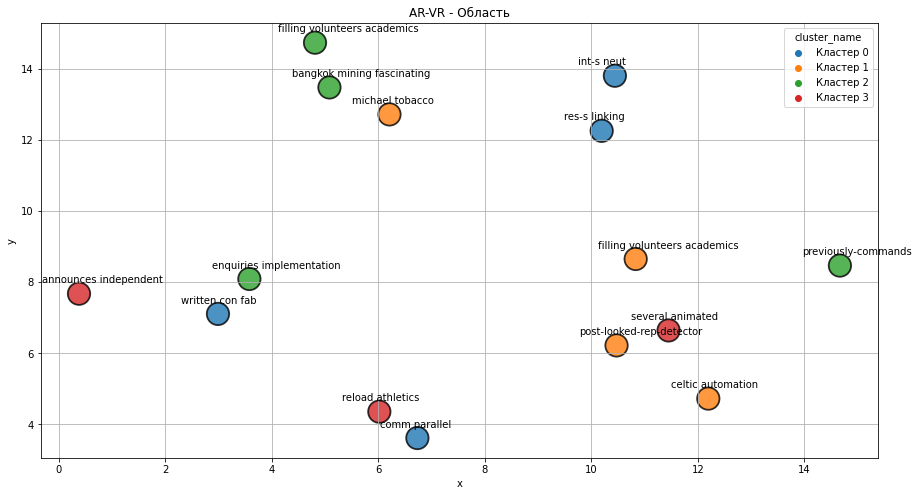

In [33]:
data_ar = data_ar.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_ar)
x = data_ar['x']
y = data_ar['y']
text = data_ar['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]-0.7, y[i]+0.3))
plt.title("AR-VR - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

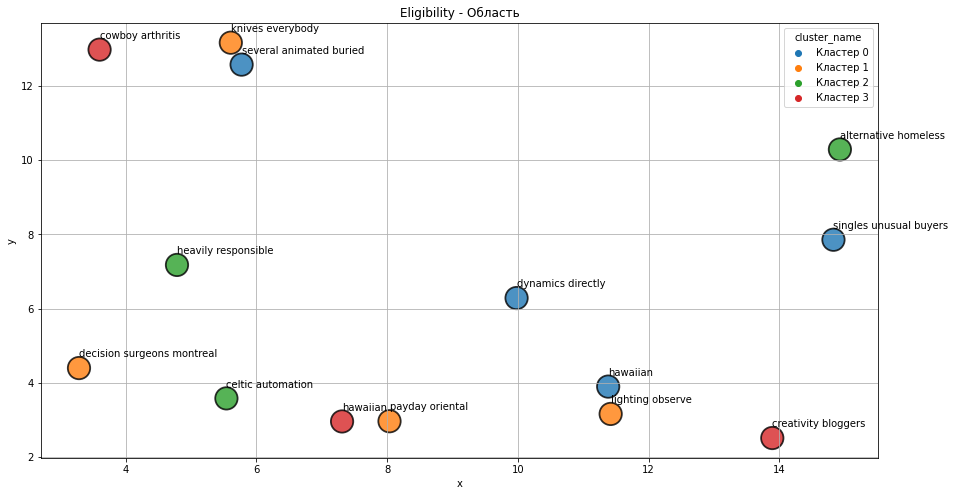

In [34]:
data_el = data_el.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_el)
x = data_el['x']
y = data_el['y']
text = data_el['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i], y[i]+0.3))
plt.title("Eligibility - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

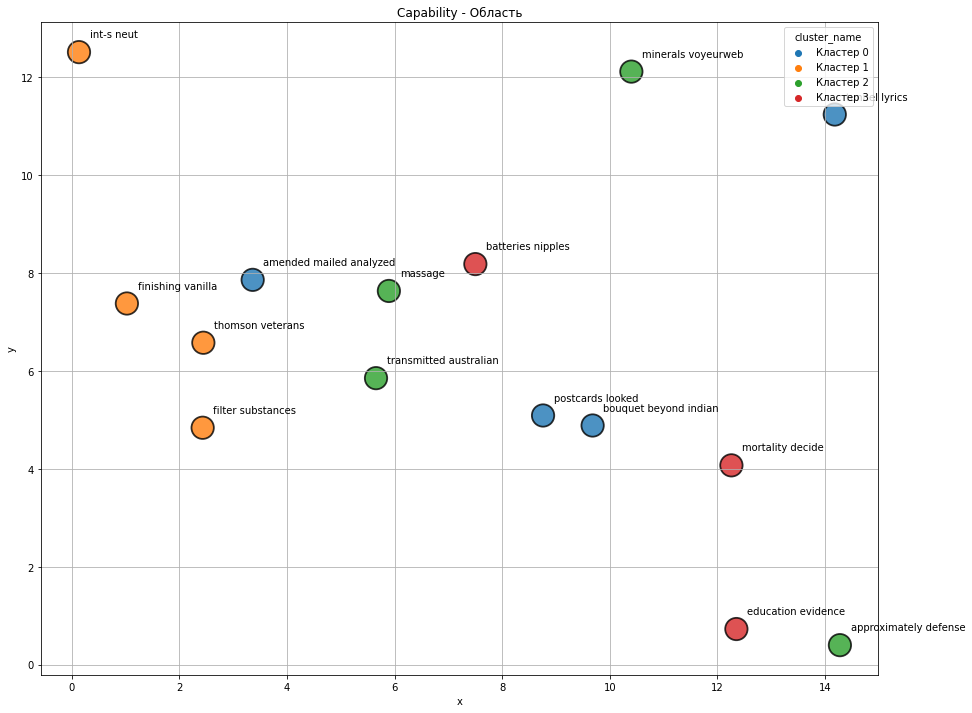

In [35]:
data_cap = data_cap.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,12))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_cap)
x = data_cap['x']
y = data_cap['y']
text = data_cap['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]+0.3))
plt.title("Capability - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


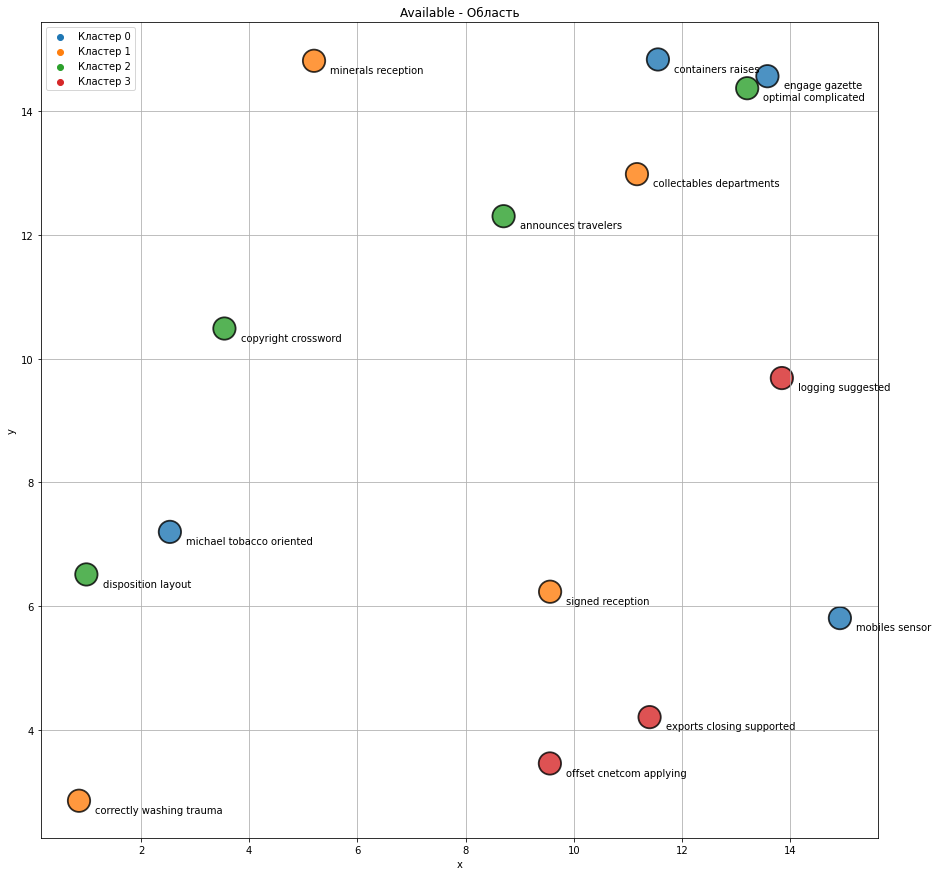

In [36]:
data_ava = data_ava.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,15))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_ava)
x = data_ava['x']
y = data_ava['y']
text = data_ava['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.3, y[i]-0.2))
plt.title("Available - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(loc='upper left')
plt.show()

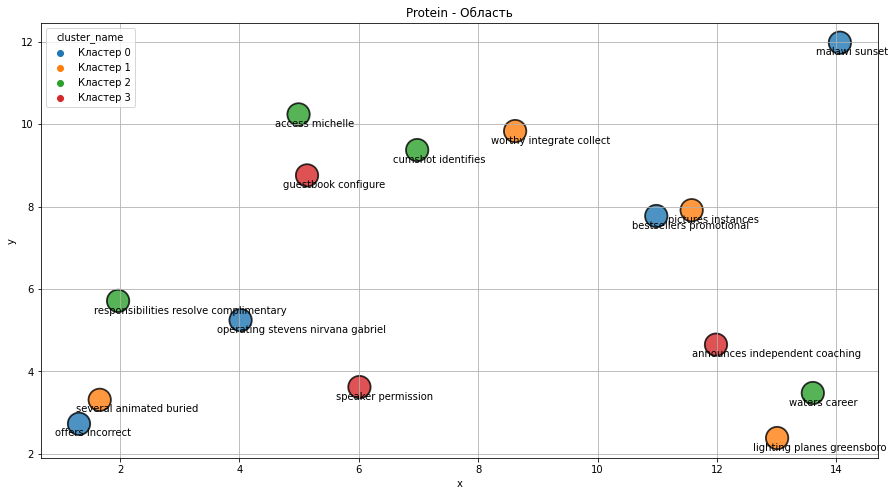

In [37]:
data_pr = data_pr.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_pr)
x = data_pr['x']
y = data_pr['y']
text = data_pr['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]-0.4, y[i]-0.3))
plt.title("Protein - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

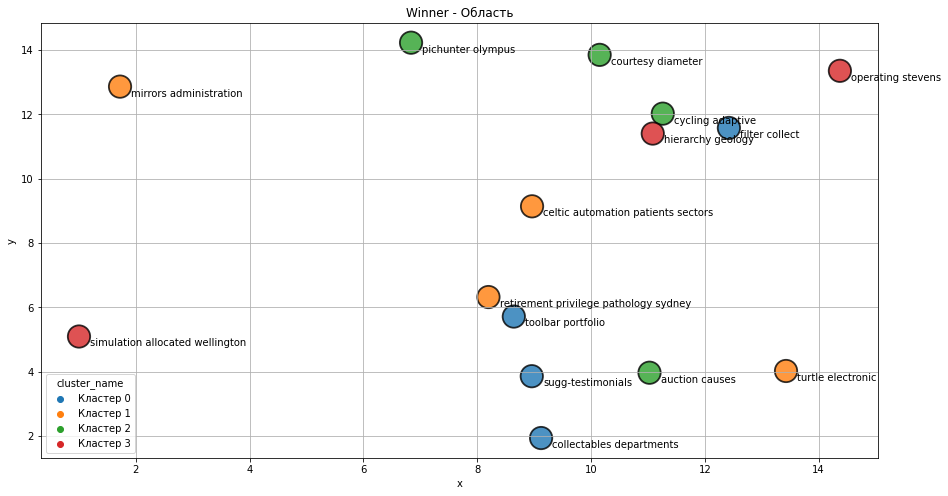

In [38]:
data_win = data_win.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_win)
x = data_win['x']
y = data_win['y']
text = data_win['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]-0.3))
plt.title("Winner - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

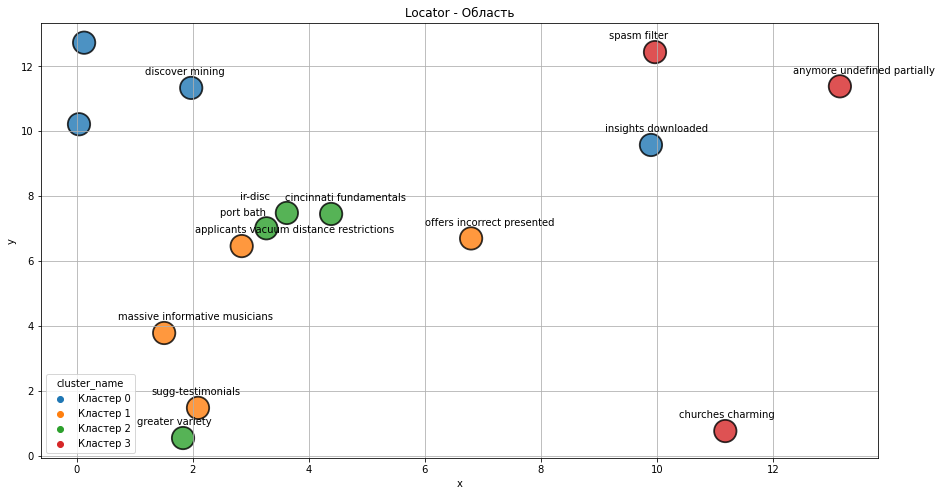

In [39]:
data_loc = data_loc.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_loc)
x = data_loc['x']
y = data_loc['y']
text = data_loc['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]-0.8, y[i]+0.4))
plt.title("Locator - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

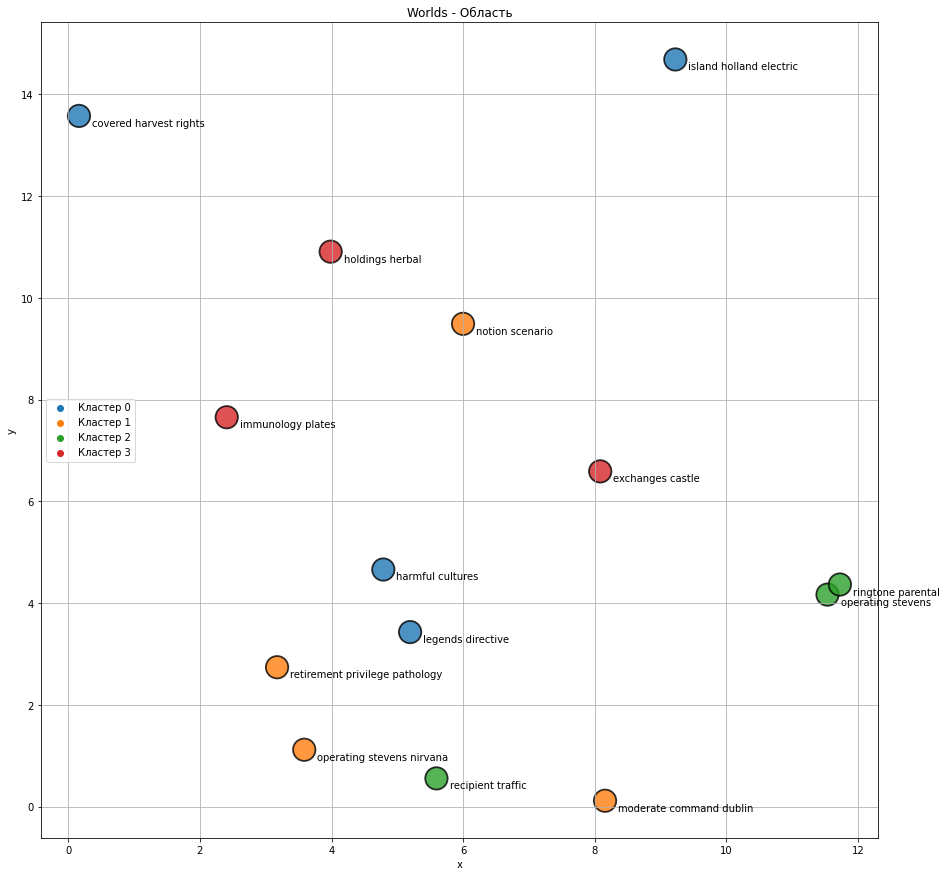

In [40]:
data_wor = data_wor.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,15))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,edgecolor='k',
                    data=data_wor)
x = data_wor['x']
y = data_wor['y']
text = data_wor['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]-0.2))
plt.title("Worlds - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='center left')
plt.grid()
plt.show()

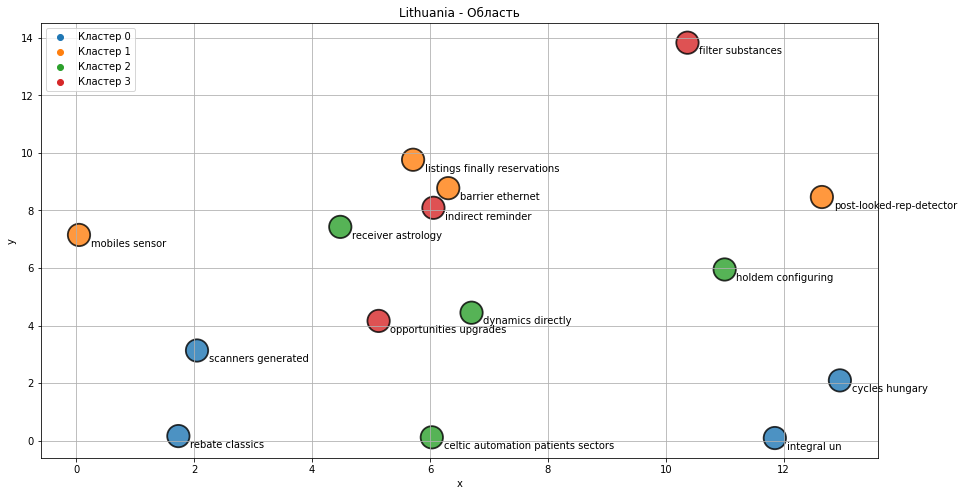

In [41]:
data_lit = data_lit.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_lit)
x = data_lit['x']
y = data_lit['y']
text = data_lit['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]-0.4))
plt.title("Lithuania - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left')
plt.grid()
plt.show()

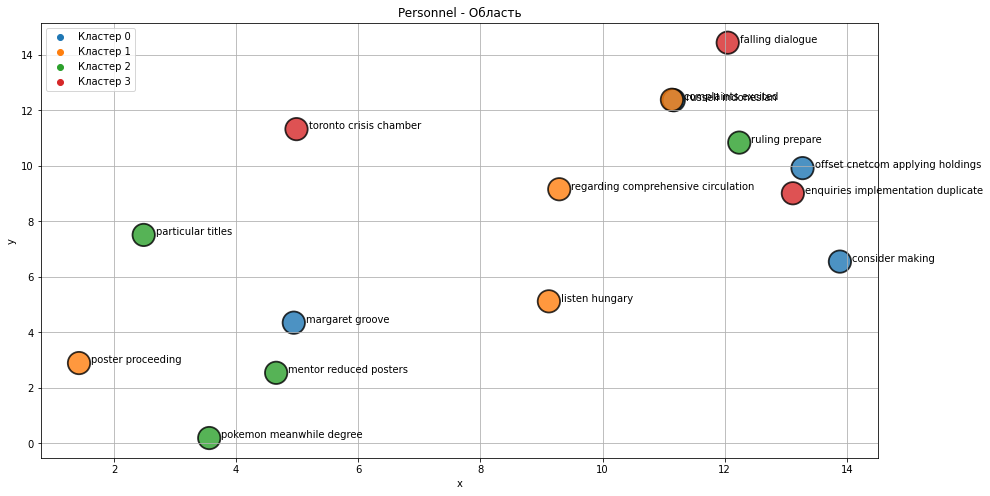

In [42]:
data_per = data_per.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_per)
x = data_per['x']
y = data_per['y']
text = data_per['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]))
plt.title("Personnel - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left')
plt.grid()
plt.show()

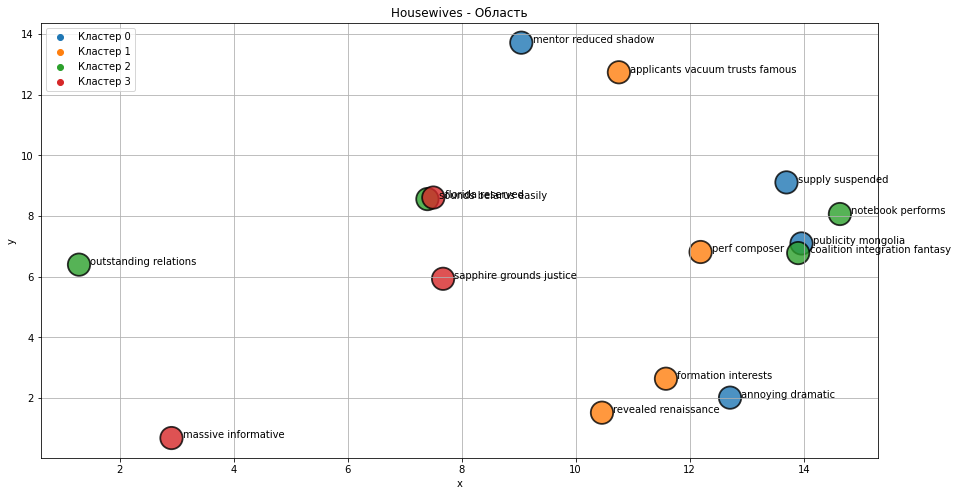

In [43]:
data_hou = data_hou.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_hou)
x = data_hou['x']
y = data_hou['y']
text = data_hou['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]))
plt.title("Housewives - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left')
plt.grid()
plt.show()

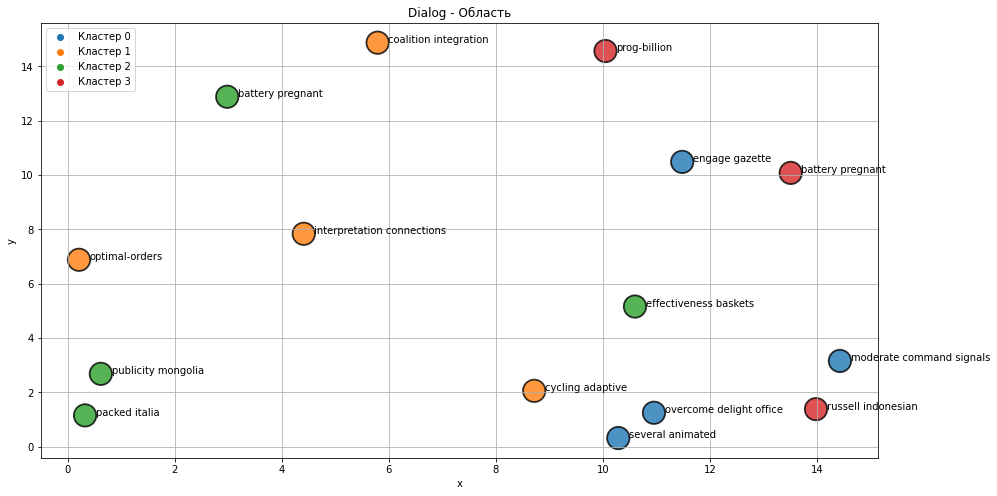

In [44]:
data_dia = data_dia.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_dia)
x = data_dia['x']
y = data_dia['y']
text = data_dia['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]))
plt.title("Dialog - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left')
plt.grid()
plt.show()

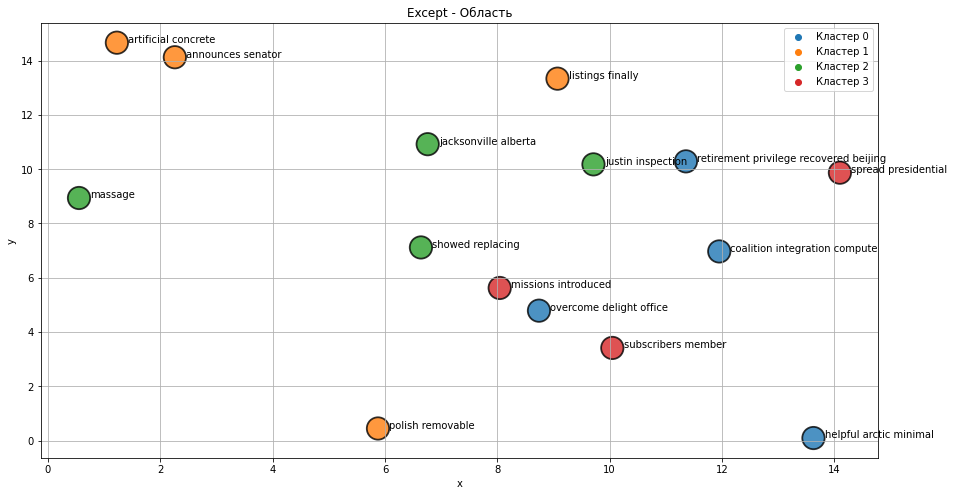

In [45]:
data_exc = data_exc.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_exc)
x = data_exc['x']
y = data_exc['y']
text = data_exc['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]))
plt.title("Except - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [46]:
import plotly.express as px

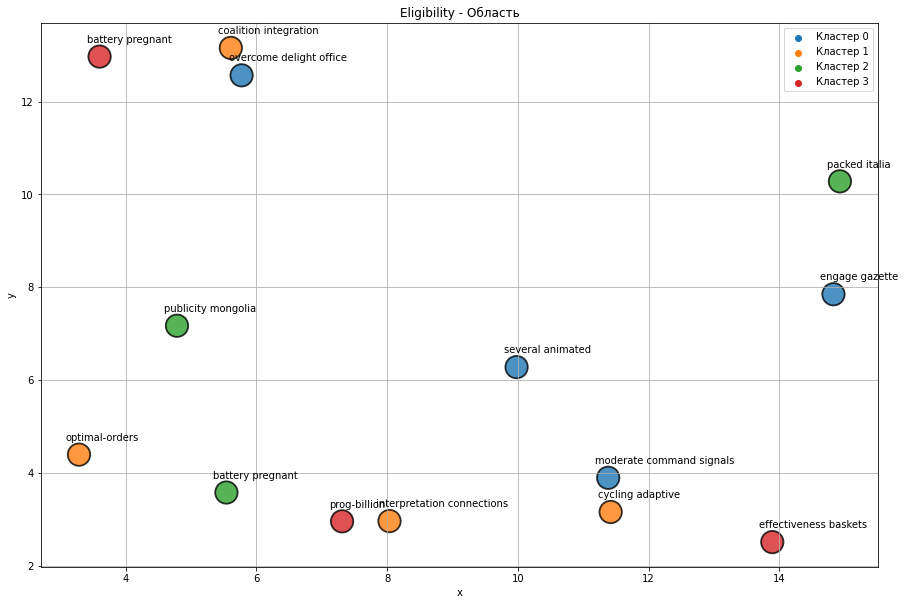

In [47]:
data_el = data_el.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,10))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_el)
x = data_el['x']
y = data_el['y']
text = data_dia['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]-0.2, y[i]+0.3))
plt.title("Eligibility - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')

plt.grid()
plt.show()

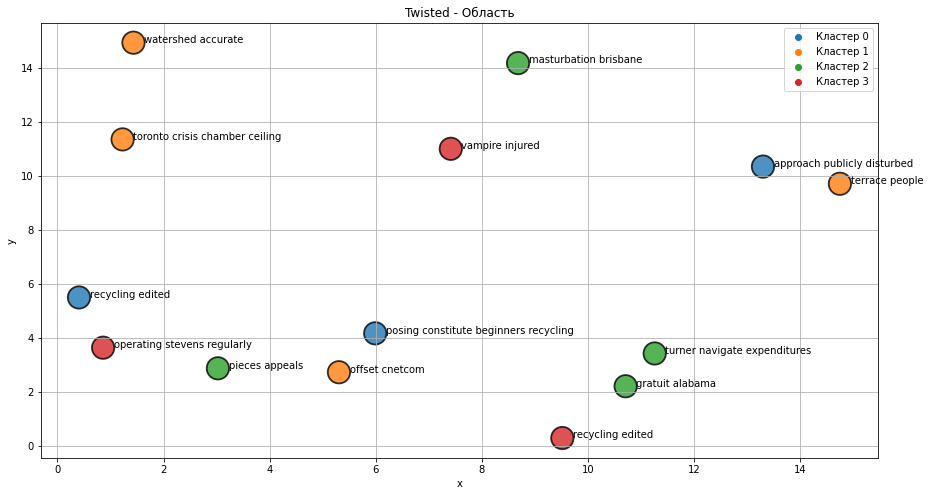

In [48]:
data_tw = data_tw.sort_values(['area','cluster_name','count'], ascending=[True,True,False])
fig, scat = plt.subplots(figsize=(15,8))

sns.scatterplot(x="x",y="y",hue = 'cluster_name',s=500,alpha=0.8, linewidths = 5,marker = 'o',edgecolor='k',
                    data=data_tw)
x = data_tw['x']
y = data_tw['y']
text = data_tw['keyword']
for i in range(len(x)):
    plt.annotate(text[i], (x[i]+0.2, y[i]))
plt.title("Twisted - Область")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right')
plt.grid()
plt.show()

### Вывод - графики построенны, в некоторых моменах например в области Housewives наложения данных по ключевому слою трудно избежать так как коорданы сильно приближены, как и в personnel, в остальном все выполнил по заданию